In [8]:
import random
import logging
import pandas as pd
from collections import namedtuple
from copy import deepcopy
from functools import reduce
import matplotlib
from matplotlib import pyplot as pltn
plt.style.use('ggplot')
%matplotlib inline

random.seed(0)
logging.basicConfig(filename='local_search.log', filemode='w', level=logging.DEBUG)


## Abstract classes

In [9]:
class Optimizer():
        
    def optimize(self):
        raise NotImplementedError

In [10]:
class Candidate:
    
    def __eq__(self, other):
        raise NotImplementedError
    
    @classmethod
    def generate_random_candidate(cls):
        raise NotImplementedError
    
    @property
    def neighbors(self):
        raise NotImplementedError
    
    @property
    def cost(self):
        raise NotImplementedError

In [11]:
class HeuristicSearch:
    
    def search(candidate):
        raise NotImplementedError
    

## The local search algorithm

In [12]:
class LocalSearch(Optimizer):
    
    def __init__(self, heuristic_search):
        self.heuristic_search = heuristic_search
        
    def optimize(self, initial_candidate):
        logging.info(f'Optimization stated with candidate: {initial_candidate}')
        previous_candidate = None
        current_candidate = initial_candidate
        n_iterations = 0
        while(previous_candidate != current_candidate):
            n_iterations += 1
            logging.info(f'Iteration number {n_iterations}')
            logging.info(f'Previous candidate: {previous_candidate}')
            previous_candidate = current_candidate
            current_candidate = self.heuristic_search.search(previous_candidate)
            logging.info(f'Next candidate: {current_candidate}')
            
        return n_iterations, current_candidate

## The search heuristics

In [13]:
class HillClimber(HeuristicSearch):
    
    def __repr__(self):
        return '<HillClimbing>'
    
    def search(self, candidate):
        
        best_candidate = candidate
        for neighbor in candidate.neighbors:
            logging.debug(f'Checking neighbor {neighbor}')
            if neighbor.cost < best_candidate.cost:
                best_candidate = neighbor
        return best_candidate
        
    

In [14]:
class FirstChoiceHillClimber(HeuristicSearch):
    
    def __repr__(self):
        return '<FirstChoiceHillClimbing>'
    
    def search(self, candidate):
        
        for neighbor in candidate.neighbors:
            logging.debug(f'Checking neighbor {neighbor}')
            if neighbor.cost < candidate.cost:
                return neighbor
        return candidate
        
    

## Candidates for the knapsack problem

In [15]:


Item = namedtuple('Item', ('weight', 'value'))
KnapSackProblem = namedtuple('KnapSackProblem', ('items', 'weight_limit'))

class KnapSackCandidate(Candidate):
    
    def __init__(self, knapsack_problem, items):
        self.problem = knapsack_problem
        self.items = items
        
    def __eq__(self, other):
        return type(self) == type(other) and self.items == other.items
        
    def __repr__(self):
        return f'<KnapSackCandidate with items {self.items}>'
    
    @classmethod
    def generate_random_candidate(cls, knapsack_problem):
        knapsack_weight = 0
        items = deepcopy(knapsack_problem.items)
        candidate_items = set()
        while(True):
            choice = random.sample(items, 1)[0]
            if not ((KnapSackCandidate.weight_sum(candidate_items) + choice.weight) 
                    > knapsack_problem.weight_limit):
                candidate_items.add(choice)
                items.remove(choice)
            else:
                return cls(knapsack_problem, items) 
            
    
    
    @staticmethod        
    def weight_sum(items):
        weight = 0
        for item in items:
            weight += item.weight
        return weight
    
    @property
    def cost(self):
        value = 0
        for item in self.items:
            value -= item.value
        return value 
    
class KnapSackCandidateSmall(KnapSackCandidate):
    
    @property
    def neighbors(self):
        neighbors = []
        # Try to exchange one item from the current candidate with all
        # other items from the knapsack problem.
        exchange_item = random.sample(self.items, 1)[0]
        for other_item in self.problem.items:
            if other_item not in self.items:
                new_items = deepcopy(self.items)
                new_items.remove(exchange_item)
                new_items.add(other_item)
                if KnapSackCandidateSmall.weight_sum(new_items) < self.problem.weight_limit:
                    neighbors.append(KnapSackCandidateSmall(self.problem, items=new_items))
        return neighbors
    
class KnapSackCandidateBig(KnapSackCandidate):
    
    @property
    def neighbors(self):
        neighbors = []
        # Try to exchange one item from the current candidate with all
        # other items from the knapsack problem or just try to add the other item
        exchange_item = random.sample(self.items, 1)[0]
        for other_item in self.problem.items:
            if other_item not in self.items:
                new_items = deepcopy(self.items)
                new_items.add(other_item)
                if KnapSackCandidateSmall.weight_sum(new_items) < self.problem.weight_limit:
                    neighbors.append(KnapSackCandidateSmall(self.problem, items=new_items))
                else:
                    new_items.remove(exchange_item)
                    if KnapSackCandidateSmall.weight_sum(new_items) < self.problem.weight_limit:
                        neighbors.append(KnapSackCandidateSmall(self.problem, items=new_items))
                
        return neighbors
        
    

Try it

In [16]:
example_problem = KnapSackProblem(items={Item(5, 10),
                                         Item(10, 1_000),
                                         Item(300, 4_000),
                                         Item(1, 5_000),
                                         Item(200, 5_000),
                                         Item(100, 2_000)}, 
                                  weight_limit=400)

local_search = LocalSearch(FirstChoiceHillClimber())
local_search.optimize(KnapSackCandidateSmall.generate_random_candidate(example_problem))

(1,
 <KnapSackCandidate with items {Item(weight=5, value=10), Item(weight=300, value=4000), Item(weight=200, value=5000)}>)

### Convenience class for systematically conducting experiments

In [17]:
class Experiment:
    def __init__(self, problems, candidate_classes, search_heuristics, runs=10):
        self.problems = problems
        self.candidate_classes = candidate_classes
        self.search_heuristics = search_heuristics
        self.runs = runs
        
    def conduct(self):
        results = pd.DataFrame(columns=['problem', 'neighborhood', 'heuristic', 'cost', 'iterations', 'run'])
        for p_idx, problem in enumerate(self.problems):
            for candidate_cls in self.candidate_classes:
                for heuristic in self.search_heuristics:
                    for run in range(self.runs):
                        local_search = LocalSearch(heuristic)
                        n_iter, best_candidate = local_search.optimize(
                            candidate_cls.generate_random_candidate(problem)
                        )
                        # Log results in dataframe.
                        results.loc[results.shape[0]] = [p_idx, 
                                                         str(candidate_cls), 
                                                         str(heuristic), 
                                                         float(best_candidate.cost),
                                                         int(n_iter),
                                                         run]
        return results

        

Let's create some problems to solve

In [18]:
example_problem = KnapSackProblem(items={Item(5, 10),
                                         Item(10, 1_000),
                                         Item(300, 4_000),
                                         Item(1, 5_000),
                                         Item(200, 5_000),
                                         Item(100, 2_000)}, 
                                  weight_limit=400)

medium_problem = KnapSackProblem(items={Item(5, 10),
                                     Item(10, 1_000),
                                     Item(300, 4_000),
                                        Item(1, 5_000),
                                        Item(1, 1_000),
                                     Item(200, 5_000),
                                     Item(100, 2_000),
                                     Item(200, 2_000), 
                                     Item(200, 3_000), 
                                     Item(500, 3_000),}, 
                                weight_limit=800)

large_problem = KnapSackProblem(items={Item(5, 10),
                                     Item(10, 1_000),
                                     Item(300, 4_000),
                                        Item(1, 5_000),
                                        Item(1, 1_000),
                                     Item(200, 5_000),
                                     Item(100, 2_000),
                                     Item(200, 2_000), 
                                     Item(200, 3_000), 
                                     Item(500, 3_000), 
                                     Item(500, 20), 
                                     Item(500, 40), 
                                     Item(5000, 20_000), 
                                     Item(50, 4_000), 
                                     Item(750, 750), 
                                     Item(10, 1_000), 
                                     Item(50, 4_000), 
                                     Item(50, 5_000), 
                                     Item(50, 6_000), 
                                     Item(300, 4_000), 
                                     Item(50, 50), 
                                     Item(50, 4_000), 
                                     Item(500, 2_000), 
                                     Item(50, 600),}, # 20 items.
                                weight_limit=5000)

In [19]:
experiment = Experiment(
    (example_problem, medium_problem, large_problem),
    (KnapSackCandidateSmall, KnapSackCandidateBig), 
    (HillClimber(), FirstChoiceHillClimber()),
    runs=500
)
results = experiment.conduct()
results[['cost', 'iterations']] = results[['cost', 'iterations']].apply(pd.to_numeric)
results


,problem,neighborhood,heuristic,cost,iterations,run
0,0,<class '__main__.KnapSackCandidateSmall'>,<HillClimbing>,-10010.0,1,0
1,0,<class '__main__.KnapSackCandidateSmall'>,<HillClimbing>,-13010.0,1,1
2,0,<class '__main__.KnapSackCandidateSmall'>,<HillClimbing>,-9000.0,1,2
3,0,<class '__main__.KnapSackCandidateSmall'>,<HillClimbing>,-7000.0,1,3
4,0,<class '__main__.KnapSackCandidateSmall'>,<HillClimbing>,-9010.0,1,4
5,0,<class '__main__.KnapSackCandidateSmall'>,<HillClimbing>,-9010.0,1,5
6,0,<class '__main__.KnapSackCandidateSmall'>,<HillClimbing>,-10000.0,2,6
7,0,<class '__main__.KnapSackCandidateSmall'>,<HillClimbing>,-11000.0,1,7
8,0,<class '__main__.KnapSackCandidateSmall'>,<HillClimbing>,-11000.0,3,8
9,0,<class '__main__.KnapSackCandidateSmall'>,<HillClimbing>,-12010.0,2,9


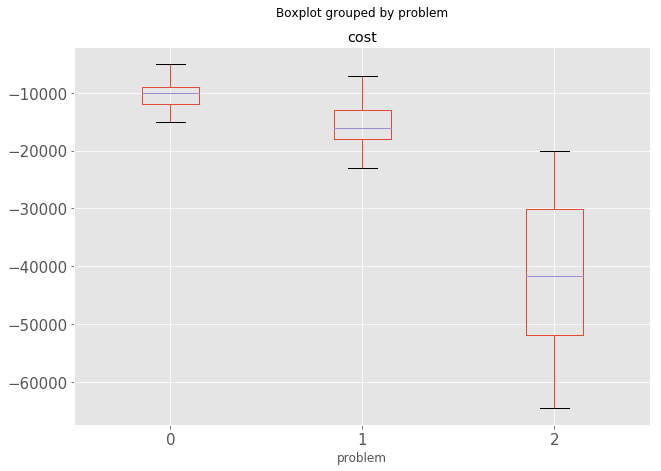

In [38]:
results.boxplot(column='cost', by='problem', figsize=(10, 7), fontsize=15)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84bf1e4160>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f84bf152400>], dtype=object)

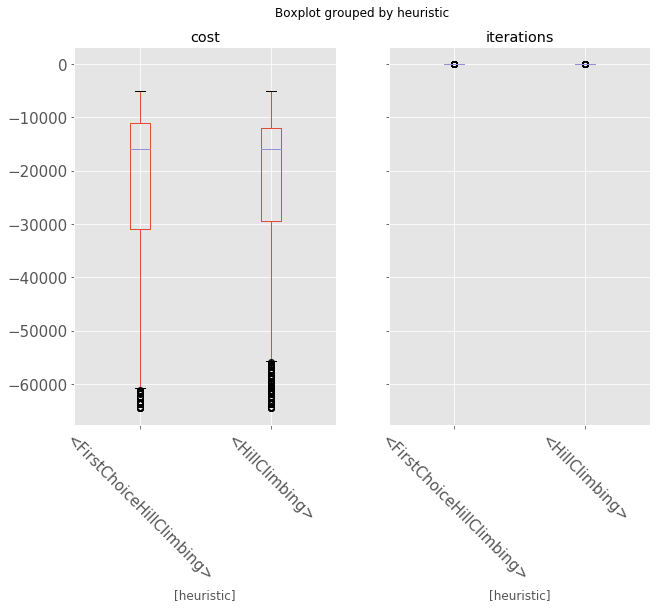

In [34]:
results.boxplot(by='heuristic', rot=-45, figsize=(10, 7), fontsize=15)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84bee92940>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f84bee05b70>], dtype=object)

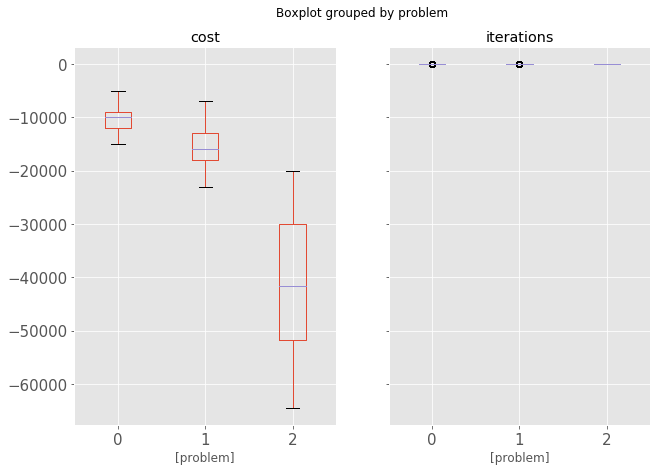

In [37]:
results.boxplot(by='problem', figsize=(10, 7), fontsize=15)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f84bf014cc0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f84bef82cf8>], dtype=object)

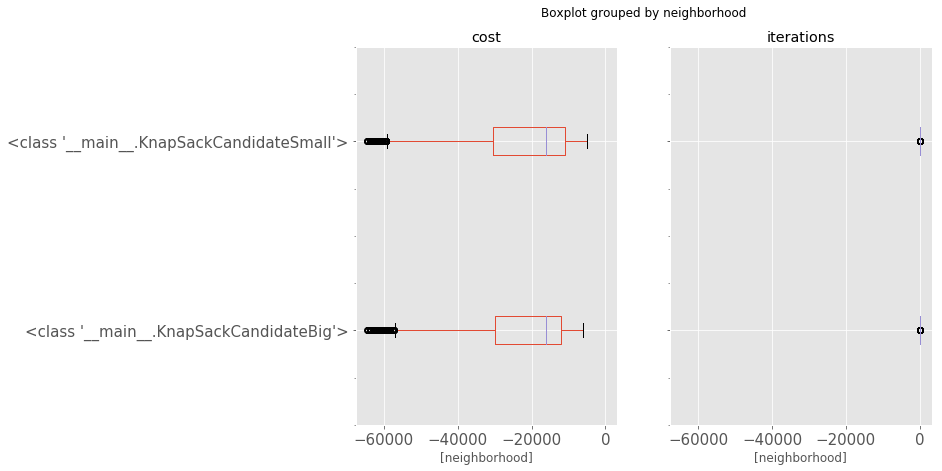

In [36]:
results.boxplot(by='neighborhood', vert=False, figsize=(10, 7), fontsize=15)

The search seems to get stuck in local minima rather quickly.

In [24]:
results['iterations'].max()

7